This will autoload the new/updated packages

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

This is the batch size

In [3]:
bs = 100
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

Function to read from JSON file

In [4]:
def readJSONFile(path):
    import json
    with open(path) as f:
        data = json.load(f)
    return data

In [5]:
dataPath=Path('/home/manoj/Documents/data/data/iwildcam-2020')
#dataPath=Path('c:/Users/manoj/PycharmProjects/data/iwildcam-2020/')
dataPath.ls()

[PosixPath('/home/manoj/Documents/data/data/iwildcam-2020/iwildcam2020_megadetector_results.json'),
 PosixPath('/home/manoj/Documents/data/data/iwildcam-2020/iwildcam2020_test_information.json'),
 PosixPath('/home/manoj/Documents/data/data/iwildcam-2020/iwildcam2020_train_annotations.json'),
 PosixPath('/home/manoj/Documents/data/data/iwildcam-2020/sample_submission.csv'),
 PosixPath('/home/manoj/Documents/data/data/iwildcam-2020/Submission20200321.csv'),
 PosixPath('/home/manoj/Documents/data/data/iwildcam-2020/test'),
 PosixPath('/home/manoj/Documents/data/data/iwildcam-2020/train')]

In [6]:
#jsonFilePath='/home/manoj/Documents/data/data/iwildcam-2020/iwildcam2020_train_annotations.json'
jsonFilePath=dataPath/'iwildcam2020_train_annotations.json'

In [7]:
data = readJSONFile(jsonFilePath)

annotations = data["annotations"]
images=data["images"]
categories = data["categories"]
info = data["info"]

# Convert to Data frame

annotations = pd.DataFrame.from_dict(annotations)
images = pd.DataFrame.from_dict(images)
categories = pd.DataFrame.from_dict(categories)


#Remove data from memory
del data

#Create column image_id to use for merging the two data frames
images["image_id"]  = images["id"]

# Merge annotations and images on image_id

trainDf1 = (pd.merge(annotations, images, on='image_id'))
#Remove Unnecessary fields
trainDf1.drop(["id_y","id_x"], axis = 1, inplace=True)

#print(trainDf1.columns)

trainDf1 = pd.merge(trainDf1, categories.rename(columns={"id":"category_id"}), on="category_id" )
# Unset annotations and images dataframe as they are no longer needed
del annotations
del images


In [8]:
categories[categories["id"]==115 ]

,count,id,name
65,3426,115,madoqua guentheri


In [9]:
categories

,count,id,name
0,78981,0,empty
1,6355,2,tayassu pecari
2,5833,3,dasyprocta punctata
3,619,4,cuniculus paca
4,4453,6,puma concolor
...,...,...,...
262,6,671,thryonomys swinderianus
263,3,672,ploceus alienus
264,3,673,ploceus baglafecht
265,2,674,poecilogale albinucha


In [10]:
trainDf1[["name","category_id"]]

,name,category_id
0,canis lupus,73
1,canis lupus,73
2,canis lupus,73
3,canis lupus,73
4,canis lupus,73
...,...,...
217954,mazama temama,571
217955,mazama temama,571
217956,mazama temama,571
217957,mazama temama,571


In [11]:
df=trainDf1[["file_name","category_id"]]
df=df.rename(columns={"file_name":"name","category_id":"label"})

#df=trainDf1[["file_name","name"]]
#df=df.rename(columns={"file_name":"name","name":"label"})

In [12]:
df

,name,label
0,96b00332-21bc-11ea-a13a-137349068a90.jpg,73
1,973073b4-21bc-11ea-a13a-137349068a90.jpg,73
2,89588844-21bc-11ea-a13a-137349068a90.jpg,73
3,87dc5806-21bc-11ea-a13a-137349068a90.jpg,73
4,96960680-21bc-11ea-a13a-137349068a90.jpg,73
...,...,...
217954,8b102e26-21bc-11ea-a13a-137349068a90.jpg,571
217955,97e76998-21bc-11ea-a13a-137349068a90.jpg,571
217956,8ee5c9fc-21bc-11ea-a13a-137349068a90.jpg,571
217957,97f875da-21bc-11ea-a13a-137349068a90.jpg,571


In [13]:
minSamples=1000
duplicateDf=pd.DataFrame()

for label in df["label"].unique():
    length=0
    
    x=min
    y=len(df[df["label"]==label])
    multiplier=1
    if(y<minSamples):
        multiplier=int(minSamples/y)
        y=y*multiplier
    #length=y
    #print("{} {} {}".format(y, multiplier, length))
    duplicateDf=duplicateDf.append([df[df["label"]==label]]*multiplier,ignore_index=True)

df=duplicateDf

In [14]:
df

,name,label
0,96b00332-21bc-11ea-a13a-137349068a90.jpg,73
1,973073b4-21bc-11ea-a13a-137349068a90.jpg,73
2,89588844-21bc-11ea-a13a-137349068a90.jpg,73
3,87dc5806-21bc-11ea-a13a-137349068a90.jpg,73
4,96960680-21bc-11ea-a13a-137349068a90.jpg,73
...,...,...
374160,8b102e26-21bc-11ea-a13a-137349068a90.jpg,571
374161,97e76998-21bc-11ea-a13a-137349068a90.jpg,571
374162,8ee5c9fc-21bc-11ea-a13a-137349068a90.jpg,571
374163,97f875da-21bc-11ea-a13a-137349068a90.jpg,571


In [15]:
tfms = get_transforms(do_flip=False)

filePath=str(dataPath/"train/400X400")

import os
print(os.getcwd())
print(filePath)
df

/home/manoj/Documents/GitHub/IWildCam2020/src
/home/manoj/Documents/data/data/iwildcam-2020/train/100X100


,name,label
0,96b00332-21bc-11ea-a13a-137349068a90.jpg,73
1,973073b4-21bc-11ea-a13a-137349068a90.jpg,73
2,89588844-21bc-11ea-a13a-137349068a90.jpg,73
3,87dc5806-21bc-11ea-a13a-137349068a90.jpg,73
4,96960680-21bc-11ea-a13a-137349068a90.jpg,73
...,...,...
374160,8b102e26-21bc-11ea-a13a-137349068a90.jpg,571
374161,97e76998-21bc-11ea-a13a-137349068a90.jpg,571
374162,8ee5c9fc-21bc-11ea-a13a-137349068a90.jpg,571
374163,97f875da-21bc-11ea-a13a-137349068a90.jpg,571


In [16]:
# This os th eold one with 200x200 px'''
i=0
while 1:
    try:
        np.random.seed(i)
        data=ImageDataBunch.from_df(filePath, df, ds_tfms=tfms, size=224, bs=100)
    except:
        i+=1
        if(i%100==0):
            print(str(i) + " did not work")
        continue
    else: 
        print('Seed '+str(i)+' works')
        break
    break
'''    

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-16-acbacf65b7f0>, line 16)

In [50]:

np.random.seed(25)
#data = ImageDataBunch.from_df("/home/manoj/Documents/data/data/iwildcam-2020/train/28X28",df, 
data = ImageDataBunch.from_df(filePath
                              , pd.DataFrame(df)
                              , ds_tfms=tfms
                              , size=224
                              , valid_pct=.2
                              , bs=bs)

TypeError: '<' not supported between instances of 'Category' and 'Category'

In [18]:
categories[categories["id"].isin([257, 229, 420, 306, 296, 402, 408, 420, 412])]

,count,id,name
106,1,229,nothocrax urumutum
120,2,257,otocyon megalotis
134,1,296,varanus salvator
139,1,306,polyplectron chalcurum
202,1,402,tragulus sp
208,1,408,leiothrix argentauris
212,2,412,erithacus cyane
220,1,420,callosciurus notatus


In [19]:
#doc(ImageDataBunch.from_df)

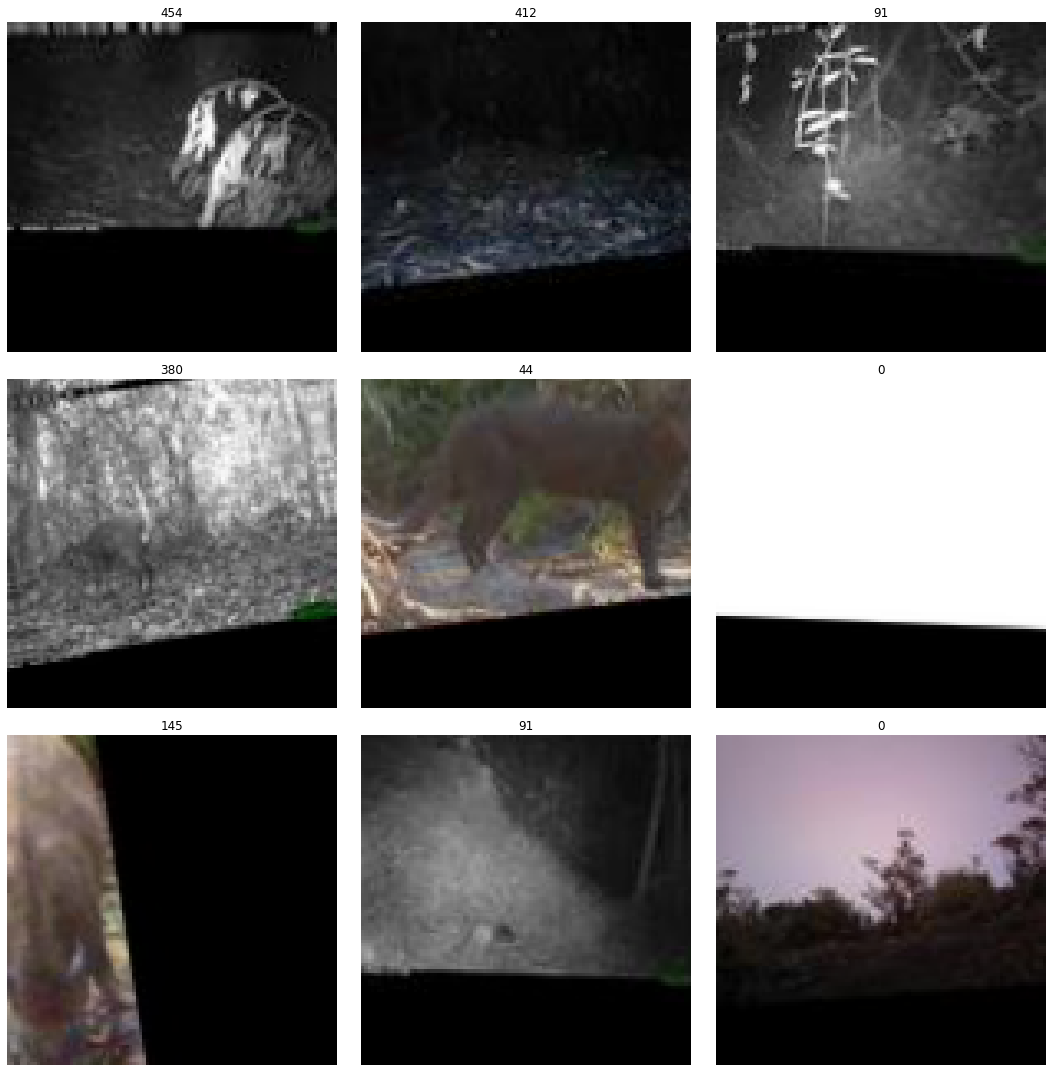

In [20]:
data.show_batch(rows=3, figsize=(15,15))

In [21]:
print(data.classes)
len(data.classes),data.c

[0, 2, 3, 4, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 20, 24, 25, 26, 32, 44, 50, 62, 67, 70, 71, 72, 73, 74, 77, 78, 79, 80, 83, 86, 89, 90, 91, 92, 94, 96, 97, 98, 99, 100, 101, 102, 103, 104, 106, 108, 110, 111, 112, 113, 114, 115, 116, 118, 119, 120, 121, 122, 123, 124, 127, 129, 130, 133, 134, 137, 139, 141, 142, 144, 145, 147, 150, 152, 153, 154, 156, 159, 161, 162, 163, 166, 167, 170, 175, 177, 198, 221, 227, 229, 230, 233, 234, 235, 240, 242, 243, 245, 250, 251, 252, 253, 256, 257, 258, 259, 262, 265, 267, 268, 273, 286, 290, 291, 292, 294, 296, 299, 300, 301, 302, 306, 307, 309, 310, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 330, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 344, 345, 346, 347, 348, 349, 350, 352, 353, 354, 355, 356, 357, 370, 371, 372, 374, 375, 376, 377, 378, 379, 380, 382, 384, 385, 389, 390, 391, 402, 404, 405, 406, 407, 408, 409, 410, 412, 413, 414, 415, 416, 417, 418, 419, 420, 422, 454, 558, 559, 561, 562, 563, 564, 565, 

(216, 216)

In [22]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
#learn = cnn_learner(data, models.resnet50, metrics=error_rate)

In [23]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [24]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,1.636692,1.155779,0.300576,01:56


In [41]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.811449,1.176055,0.307618,01:55
1,1.196076,0.845301,0.237101,01:53
2,1.055709,0.775786,0.216776,01:53


Training Loss is greater than validation loss. Something isn't right

In [84]:
import torch
torch.cuda.empty_cache()

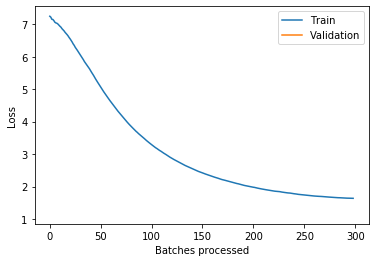

In [25]:
learn.recorder.plot_losses()

In [24]:
learn.save('stage-1.50.040100')

In [33]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

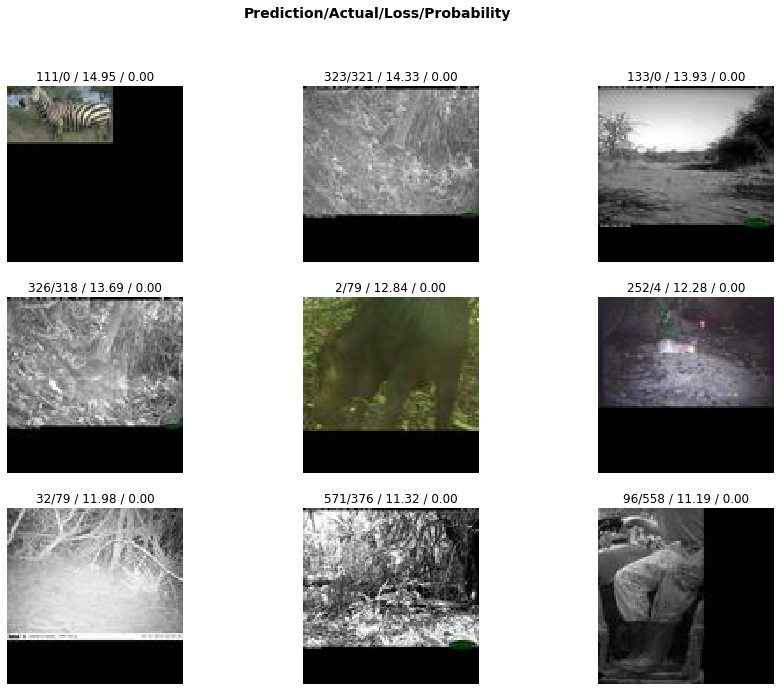

In [34]:
interp.plot_top_losses(9, figsize=(15,11))

In [22]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

KeyboardInterrupt: 

In [35]:
interp.most_confused(min_val=2)

[(374, 372, 316),
 (372, 374, 280),
 (79, 0, 189),
 (24, 10, 148),
 (115, 0, 136),
 (6, 10, 132),
 (558, 372, 132),
 (374, 3, 130),
 (103, 96, 124),
 (90, 96, 111),
 (371, 372, 110),
 (299, 0, 100),
 (371, 10, 100),
 (144, 0, 95),
 (372, 3, 94),
 (376, 10, 93),
 (3, 372, 91),
 (375, 10, 90),
 (6, 372, 88),
 (96, 0, 88),
 (372, 558, 87),
 (24, 372, 86),
 (291, 0, 86),
 (3, 374, 83),
 (380, 3, 79),
 (10, 375, 77),
 (374, 558, 76),
 (243, 10, 75),
 (0, 372, 74),
 (380, 372, 74),
 (371, 3, 71),
 (137, 0, 69),
 (240, 372, 68),
 (0, 96, 66),
 (6, 374, 65),
 (290, 0, 65),
 (10, 24, 64),
 (71, 96, 64),
 (115, 96, 64),
 (315, 317, 63),
 (309, 0, 61),
 (371, 375, 60),
 (79, 372, 59),
 (50, 10, 58),
 (380, 374, 55),
 (152, 0, 54),
 (153, 0, 54),
 (6, 3, 53),
 (371, 374, 51),
 (96, 71, 50),
 (558, 3, 50),
 (558, 374, 49),
 (0, 3, 47),
 (0, 10, 46),
 (318, 91, 46),
 (24, 3, 44),
 (70, 72, 44),
 (99, 372, 43),
 (371, 243, 43),
 (26, 374, 42),
 (2, 372, 41),
 (10, 243, 41),
 (79, 2, 41),
 (380, 317, 

In [26]:
learn.unfreeze()

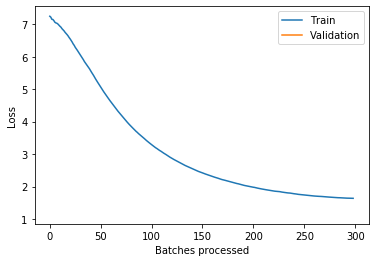

In [27]:
learn.recorder.plot_losses() # This os th eold one with 200x200 px

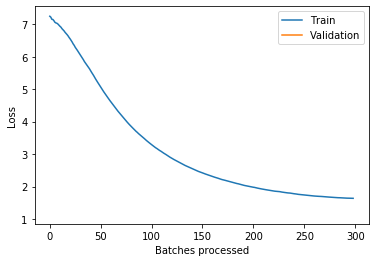

In [28]:
learn.recorder.plot_losses() 

Check the model after unfreezing

In [29]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,time
0,0.992511,0.694252,0.195261,02:30
1,0.668196,0.541158,0.154878,02:29
2,0.519089,0.433713,0.126361,02:29
3,0.401260,0.392303,0.114214,02:29
4,0.303282,0.291283,0.083185,02:29
5,0.226906,0.224430,0.065265,02:29
6,0.157098,0.169387,0.049270,02:29
7,0.111020,0.139470,0.039608,02:29
8,0.083070,0.121108,0.033849,02:29
9,0.068694,0.118307,0.032833,02:29


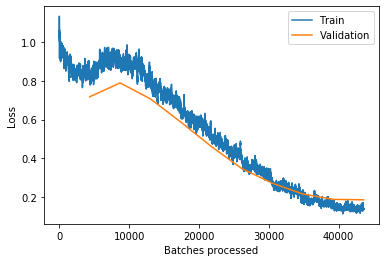

In [30]:
learn.recorder.plot_losses()

In [61]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,error_rate,time
0,0.371422,0.342109,0.087656,24:33
1,0.192901,0.197599,0.050309,24:34


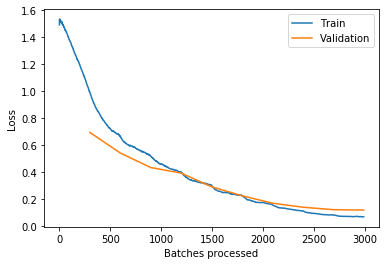

In [30]:
learn.recorder.plot_losses()

In [87]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,time
0,0.157971,0.211817,0.051364,24:38
1,0.329609,0.282852,0.072538,24:35
2,0.381062,0.347307,0.091051,24:41
3,0.369202,0.345926,0.086967,24:25
4,0.334514,0.267006,0.066688,24:33
5,0.225194,0.226354,0.055172,24:59


KeyboardInterrupt: 

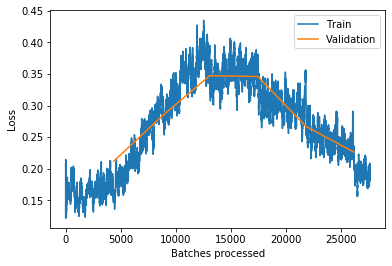

In [88]:
learn.recorder.plot_losses()

The training losses are still greater than validation losses

Much better! But can be better. Maybe the learning rate needs to be reduced!

In [89]:
##learn.save('stage-1.34.033111') # 200X200 images best so far 0.699
#learn.save('stage-1.34.040110') # 400X400 images 0.645
learn.save('stage-1.34.040116') # 400X400 images

In [91]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 11.00 GiB total capacity; 6.78 GiB already allocated; 1.62 MiB free; 6.81 GiB reserved in total by PyTorch)

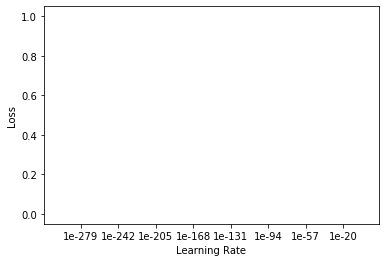

In [92]:
learn.recorder.plot()

In [33]:
#learn.fit_one_cycle(4, max_lr=slice(7e-4,9e-3))

Maybe a few more fittings will make the losses better

In [34]:
learn.save('stage-1.50.040101')

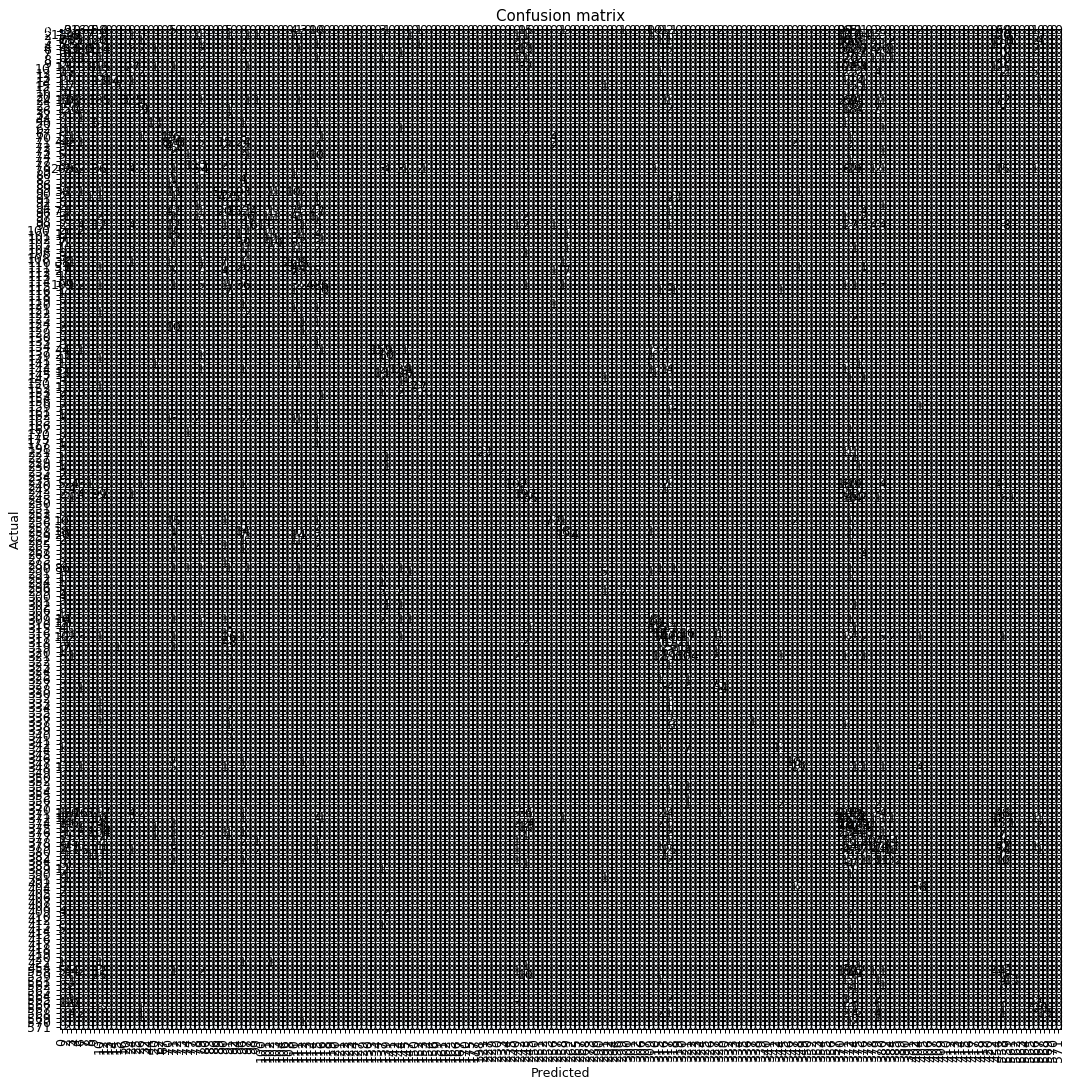

In [35]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=90)

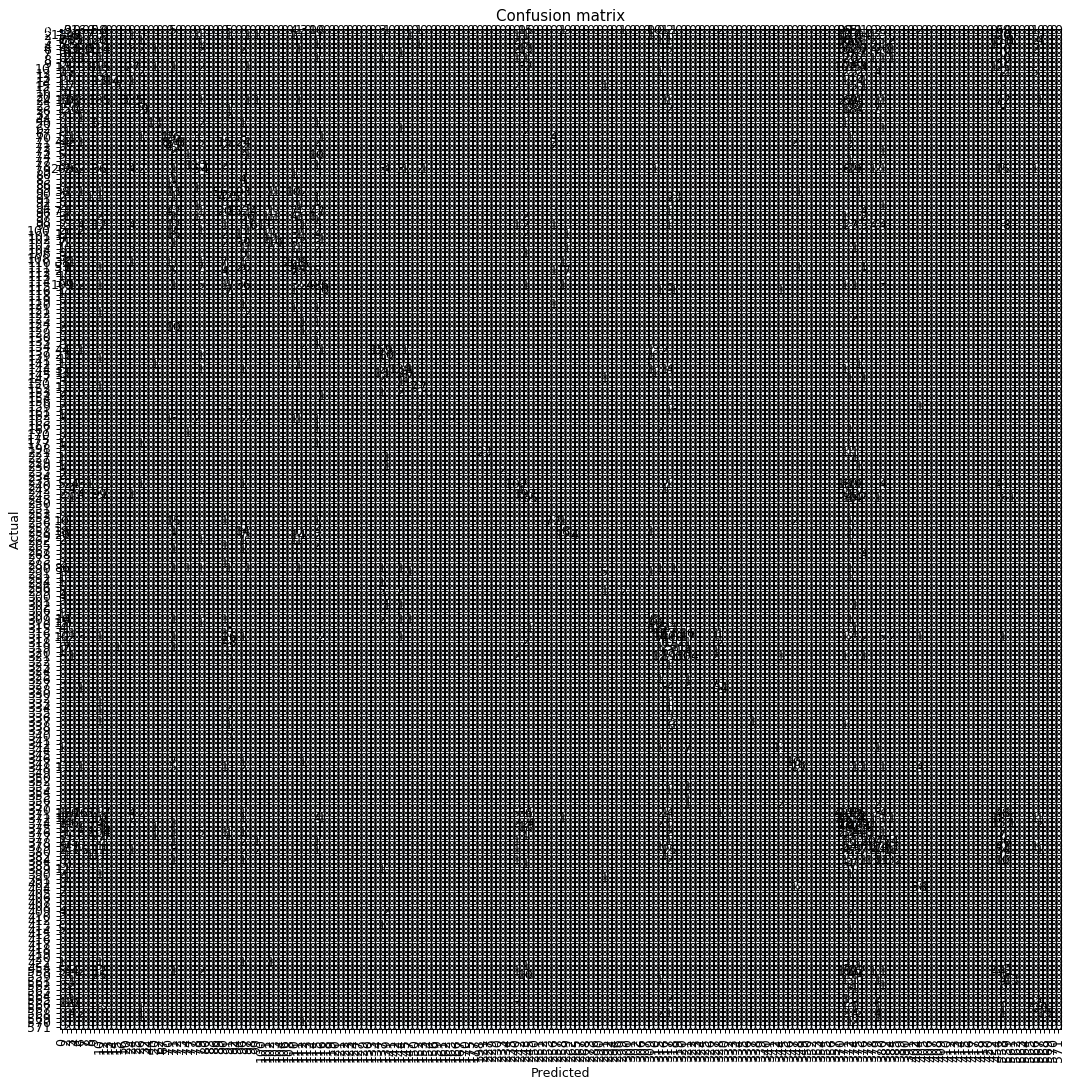

In [93]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=90)

In [31]:
#jsonTestFilePath='/home/manoj/Documents/data/data/iwildcam-2020/iwildcam2020_test_information.json'
jsonTestFilePath=dataPath/'iwildcam2020_test_information.json'
testData = readJSONFile(jsonTestFilePath)

testImages=testData["images"]
testCategories = testData["categories"]
testInfo = testData["info"]

# Convert to Data frame

testImages = pd.DataFrame.from_dict(testImages)
testCategories = pd.DataFrame.from_dict(testCategories)

#Remove data from memory
del testData, testInfo

# Remove Unnecessary fields from images
testDf1 = pd.DataFrame(testImages.file_name)
    

In [95]:
testImages

,seq_num_frames,location,datetime,id,frame_num,seq_id,width,height,file_name
0,1,84,2013-08-02 21:44:00.000,88037cce-21bc-11ea-a13a-137349068a90,1,88037e90-21bc-11ea-a13a-137349068a90,2771,1779,88037cce-21bc-11ea-a13a-137349068a90.jpg
1,1,84,2013-08-02 21:51:00.000,963e6b46-21bc-11ea-a13a-137349068a90,1,963e6cb8-21bc-11ea-a13a-137349068a90,2771,1779,963e6b46-21bc-11ea-a13a-137349068a90.jpg
2,1,548,2013-04-25 18:23:00.000,8a1b53ba-21bc-11ea-a13a-137349068a90,1,8a1b5554-21bc-11ea-a13a-137349068a90,2895,1865,8a1b53ba-21bc-11ea-a13a-137349068a90.jpg
3,1,181,2013-04-17 16:10:00.000,938c0d5e-21bc-11ea-a13a-137349068a90,1,938c0f02-21bc-11ea-a13a-137349068a90,2902,1818,938c0d5e-21bc-11ea-a13a-137349068a90.jpg
4,1,181,2013-04-20 03:11:00.000,95b9bd92-21bc-11ea-a13a-137349068a90,1,95b9be96-21bc-11ea-a13a-137349068a90,2212,1841,95b9bd92-21bc-11ea-a13a-137349068a90.jpg
...,...,...,...,...,...,...,...,...,...
62889,-1,5,2013-08-01 18:45:20.000,978d4224-21bc-11ea-a13a-137349068a90,-1,995a6da2-21bc-11ea-a13a-137349068a90,1280,1024,978d4224-21bc-11ea-a13a-137349068a90.jpg
62890,-1,5,2013-08-01 18:45:21.000,8bd8cad4-21bc-11ea-a13a-137349068a90,-1,995a6da2-21bc-11ea-a13a-137349068a90,1280,1024,8bd8cad4-21bc-11ea-a13a-137349068a90.jpg
62891,-1,5,2013-08-01 18:45:22.000,8c894fc6-21bc-11ea-a13a-137349068a90,-1,995a6da2-21bc-11ea-a13a-137349068a90,1280,1024,8c894fc6-21bc-11ea-a13a-137349068a90.jpg
62892,-1,5,2013-08-01 18:45:22.000,97bffbf6-21bc-11ea-a13a-137349068a90,-1,995a6da2-21bc-11ea-a13a-137349068a90,1280,1024,97bffbf6-21bc-11ea-a13a-137349068a90.jpg


In [32]:
#testPath=Path("/home/manoj/Documents/data/data/iwildcam-2020/test/100X100")
testPath=dataPath/'test/100X100'

In [97]:
testPath.ls()[10]

WindowsPath('c:/Users/manoj/PycharmProjects/data/iwildcam-2020/test/400X400/8676929c-21bc-11ea-a13a-137349068a90.jpg')

In [98]:
for i, file in enumerate(testPath.ls()):
    if (i < 10) :
        print(file)

c:\Users\manoj\PycharmProjects\data\iwildcam-2020\test\400X400\867611a0-21bc-11ea-a13a-137349068a90.jpg
c:\Users\manoj\PycharmProjects\data\iwildcam-2020\test\400X400\86761d58-21bc-11ea-a13a-137349068a90.jpg
c:\Users\manoj\PycharmProjects\data\iwildcam-2020\test\400X400\867624e2-21bc-11ea-a13a-137349068a90.jpg
c:\Users\manoj\PycharmProjects\data\iwildcam-2020\test\400X400\86762942-21bc-11ea-a13a-137349068a90.jpg
c:\Users\manoj\PycharmProjects\data\iwildcam-2020\test\400X400\86763c0c-21bc-11ea-a13a-137349068a90.jpg
c:\Users\manoj\PycharmProjects\data\iwildcam-2020\test\400X400\86765afc-21bc-11ea-a13a-137349068a90.jpg
c:\Users\manoj\PycharmProjects\data\iwildcam-2020\test\400X400\867665c4-21bc-11ea-a13a-137349068a90.jpg
c:\Users\manoj\PycharmProjects\data\iwildcam-2020\test\400X400\86766cf4-21bc-11ea-a13a-137349068a90.jpg
c:\Users\manoj\PycharmProjects\data\iwildcam-2020\test\400X400\86767820-21bc-11ea-a13a-137349068a90.jpg
c:\Users\manoj\PycharmProjects\data\iwildcam-2020\test\400X400\8

In [99]:
learn.predict(open_image(testPath.ls()[1]), True)[1]

Category 258

In [100]:
for i, file in enumerate(testPath.ls()):
    if (i < 10) :
        print(learn.predict(open_image(testPath.ls()[i]))[0])

0
258
380
26
24
380
111
0
558
0


In [101]:
i=0
for file in testPath.ls():
    if (i < 10) :
        print(learn.predict(open_image(file))[0])
        i=i+1

0
258
380
26
24
380
111
0
558
0


In [33]:
#df=[ {"file_name":str(file).replace(str(testPath)+'/',''), "name": learn.predict(open_image(file))[0] }
df=[ {"file_name":str(file).replace(str(testPath)+'/',''), "Id": learn.predict(open_image(file))[0] }
    for file in testPath.ls()[:]
]

In [34]:
df=pd.DataFrame(df)

In [35]:
df

,file_name,Id
0,867611a0-21bc-11ea-a13a-137349068a90.jpg,152
1,86761d58-21bc-11ea-a13a-137349068a90.jpg,96
2,867624e2-21bc-11ea-a13a-137349068a90.jpg,0
3,86762942-21bc-11ea-a13a-137349068a90.jpg,0
4,86763c0c-21bc-11ea-a13a-137349068a90.jpg,371
...,...,...
62890,995a286a-21bc-11ea-a13a-137349068a90.jpg,115
62891,995a3fda-21bc-11ea-a13a-137349068a90.jpg,0
62892,995a4dfe-21bc-11ea-a13a-137349068a90.jpg,99
62893,995a548e-21bc-11ea-a13a-137349068a90.jpg,372


In [36]:
dforg=df

In [37]:
#os.path.basename(df["file_name"][0])

df["file_name"]=list(map(lambda x: os.path.basename(x), df["file_name"]))


In [38]:
#jsonSubmissionFilePath='/home/manoj/Documents/data/data/iwildcam-2020/sample_submission.csv'
jsonSubmissionFilePath=dataPath/'sample_submission.csv'
submission=pd.read_csv(jsonSubmissionFilePath)

In [39]:
submission.drop(columns=["Category"], inplace=True)
submission

,Id
0,873ff218-21bc-11ea-a13a-137349068a90
1,884103be-21bc-11ea-a13a-137349068a90
2,973feb64-21bc-11ea-a13a-137349068a90
3,8ebf4e44-21bc-11ea-a13a-137349068a90
4,95a33464-21bc-11ea-a13a-137349068a90
...,...
62865,976c0b90-21bc-11ea-a13a-137349068a90
62866,92f567fa-21bc-11ea-a13a-137349068a90
62867,9692fb2a-21bc-11ea-a13a-137349068a90
62868,8b0412f8-21bc-11ea-a13a-137349068a90


In [40]:
testXref=testImages[["file_name","id"]]

In [41]:
len(testXref)

62894

In [42]:
#testXref.groupby('file_name').first()
df.merge(testXref, on='file_name')

,file_name,Id,id
0,867611a0-21bc-11ea-a13a-137349068a90.jpg,152,867611a0-21bc-11ea-a13a-137349068a90
1,86761d58-21bc-11ea-a13a-137349068a90.jpg,96,86761d58-21bc-11ea-a13a-137349068a90
2,867624e2-21bc-11ea-a13a-137349068a90.jpg,0,867624e2-21bc-11ea-a13a-137349068a90
3,86762942-21bc-11ea-a13a-137349068a90.jpg,0,86762942-21bc-11ea-a13a-137349068a90
4,86763c0c-21bc-11ea-a13a-137349068a90.jpg,371,86763c0c-21bc-11ea-a13a-137349068a90
...,...,...,...
62889,995a286a-21bc-11ea-a13a-137349068a90.jpg,115,995a286a-21bc-11ea-a13a-137349068a90
62890,995a3fda-21bc-11ea-a13a-137349068a90.jpg,0,995a3fda-21bc-11ea-a13a-137349068a90
62891,995a4dfe-21bc-11ea-a13a-137349068a90.jpg,99,995a4dfe-21bc-11ea-a13a-137349068a90
62892,995a548e-21bc-11ea-a13a-137349068a90.jpg,372,995a548e-21bc-11ea-a13a-137349068a90


In [43]:
#df1=df.merge(testImages, on='file_name')[["id","name"]]
df1=df.merge(testXref, on='file_name')[["id","Id"]]
#df1=df1.rename(columns={"id":"Id"})
df1=df1.rename(columns={"Id":"Category", "id":"Id"})

In [44]:
df1

,Id,Category
0,867611a0-21bc-11ea-a13a-137349068a90,152
1,86761d58-21bc-11ea-a13a-137349068a90,96
2,867624e2-21bc-11ea-a13a-137349068a90,0
3,86762942-21bc-11ea-a13a-137349068a90,0
4,86763c0c-21bc-11ea-a13a-137349068a90,371
...,...,...
62889,995a286a-21bc-11ea-a13a-137349068a90,115
62890,995a3fda-21bc-11ea-a13a-137349068a90,0
62891,995a4dfe-21bc-11ea-a13a-137349068a90,99
62892,995a548e-21bc-11ea-a13a-137349068a90,372


In [45]:
#df2=submission.merge(df1, on="Id")[["Id","Category"]]
df2=submission.merge(df1, on="Id")

In [46]:
df2

,Id,Category
0,873ff218-21bc-11ea-a13a-137349068a90,0
1,884103be-21bc-11ea-a13a-137349068a90,96
2,973feb64-21bc-11ea-a13a-137349068a90,372
3,8ebf4e44-21bc-11ea-a13a-137349068a90,24
4,95a33464-21bc-11ea-a13a-137349068a90,24
...,...,...
62865,976c0b90-21bc-11ea-a13a-137349068a90,374
62866,92f567fa-21bc-11ea-a13a-137349068a90,24
62867,9692fb2a-21bc-11ea-a13a-137349068a90,0
62868,8b0412f8-21bc-11ea-a13a-137349068a90,0


In [47]:
#df["file_name"]

In [48]:
df2.to_csv("submission.2020040200.csv", index=False)

In [ ]:
preds, y, losses = learn.get_preds(ds_type=DatasetType.Test, with_loss=True)
#y = torch.argmax(preds, dim=1)

In [49]:
!pwd

/home/manoj/Documents/GitHub/IWildCam2020/src


In [ ]:
learn1 = cnn_learner(data, models.resnet34, metrics=error_rate)